## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [87]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [88]:
# load the dataset into a dataframe and have a look
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [89]:
#len(df)
df.shape[0]

294478

c. The number of unique users in the dataset.

In [90]:
#number of unique users in the dataset.
df.user_id.nunique()

290584

d. The proportion of users converted.

In [91]:
#The proportion of users converted can be caculated by mean function as it's boolean values
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [92]:
#number of times the new_page and treatment don't line up.
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

f. Do any of the rows have missing values?

In [93]:
# checking non-null accross all coloumns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


<b>Answer: </b>
No missing values found

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [94]:
df2=df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) != False]

In [95]:
# Double Check all of the incorrect rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [96]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [97]:
df2[df2.duplicated(['user_id'])].user_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [98]:
df2[df2.duplicated(['user_id'])]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [99]:
#drop duplicated row
df2.drop_duplicates(['user_id'],inplace=True)

<ipython-input-99-aa0f6001ba8e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.drop_duplicates(['user_id'],inplace=True)


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [100]:
#probability of an individual converting regardless of the page they receive
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [101]:
#probability they converted Given that an individual was in the control group
df2.query('group=="control"').converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [102]:
#probability they converted Given that an individual was in the treatment group
df2.query('group=="treatment"').converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [103]:
#probability that an individual received the new page
df2.query('landing_page=="new_page"').shape[0]/df2.shape[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Answer** Based on the outputs above,the control group has a higher conversion than the treatment group.However, this difference is not that much and we can consider it approximately the same so, I don't think this is a sufficient evedience to decide clearly.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Answer**



 $$H_0: p_{new} - p_{old} =< 0$$


 $$H_1: p_{new} - p_{old} > 0$$


`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [104]:
#how many users are converted
p_new=df2.converted.mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [105]:
#following the null hypothesis here's an assumption that pnew=pold
p_old=df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [106]:
#no of users got the new page
n_new=df2.query('landing_page == "new_page"').shape[0]
n_new

145310

d. What is $n_{old}$?

In [107]:
#no of users got the old page
n_old=df2.query('landing_page == "old_page"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [108]:
# simulating n_new transaction that have probabiliy of receiving new page
new_page_converted=np.random.choice([1,0],size=n_new,p=[p_new,1-p_new])
new_page_converted.mean()

0.12021196063588191

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [109]:
# simulating n_new transaction that have probabiliy of receiving old page

old_page_converted=np.random.choice([1,0],size=n_old,p=[p_old,1-p_old])
old_page_converted.mean()

0.1185965830086595

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [110]:
#calculate difference between simulations
p_diff=new_page_converted.mean()-old_page_converted.mean()
p_diff

0.001615377627222414

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [111]:
# running simulation on sample

p_diffs=[]

for _ in range(10000):
    new_page_converted=np.random.choice([1,0],size=n_new,p=[p_new,1-p_new])
    old_page_converted=np.random.choice([1,0],size=n_old,p=[p_old,1-p_old])
    p_diff=new_page_converted.mean()-old_page_converted.mean()
    p_diffs.append(p_diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

Text(0, 0.5, 'difference frequency')

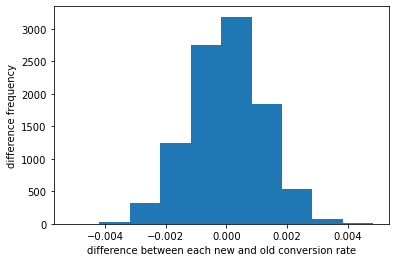

In [112]:
#convert p_diffs into numpy array
p_diffs=np.array(p_diffs)

# plot sampling distribution
plt.hist(p_diffs)
plt.xlabel('difference between each new and old conversion rate')
plt.ylabel('difference frequency')

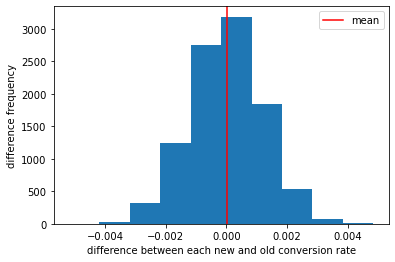

In [113]:
#plot line for observed statistics
plt.hist(p_diffs)
plt.xlabel('difference between each new and old conversion rate')
plt.ylabel('difference frequency')
plt.axvline(p_diffs.mean(), color='r', label='mean')
plt.legend()

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [114]:
old_observed=df2.query('landing_page == "old_page"').converted
new_observed=df2.query('landing_page == "new_page"').converted
p_observed = new_observed.mean()-old_observed.mean()
p_observed

-0.0015782389853555567

In [115]:
#calculating the proportion of p_diffs greater than the actual observe difference
(p_diffs > p_observed).mean()

0.907

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer:** <ul>This is what's called scientifically the **p-value**.</ul>
<ul>In statistics, the p-value is the probability of obtaining results at least as extreme as the observed results of a statistical hypothesis test, assuming that the null hypothesis is correct. The p-value is used as an alternative to rejection points to provide the smallest level of significance at which the null hypothesis would be rejected. A smaller p-value means that there is stronger evidence in favor of the alternative hypothesis.</ul>

<ul>As the definition above clarified,the p-value we have in this case is too big so can confidentially say that we fail to reject null hypothesis and the graph shows that too</ul>

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [116]:
import statsmodels.api as sm

old_converted = df2.query('group == "control" & converted == 1').converted.shape[0]
new_converted = df2.query('group == "treatment" & converted == 1').converted.shape[0]
new_converted,old_converted

(17264, 17489)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [117]:
##another approach to find p-value using z-score ready maid function

z_score, p_value = sm.stats.proportions_ztest([old_converted, new_converted],
                                              [n_old, n_new],
                                              alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer:**
<ul>The z-score and p-value found in this implementation completely agree with AB testing results as we have a large p-value that makes us fail to reject null hypothesis</ul>

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Answer:** Logistic Regression as it is used to predict the categorical variable and here in our case we have a classification problem either the page is converted **(1)** or not **(0)**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [118]:
#define intercept coloumn
df2['intercept']=1

# create boolean interpretation for the new page and its corresponding group treatment
df2[['new_page_dummy','old_page_dummy']]=pd.get_dummies(df2['landing_page'])
df2[['ab_page_treatment','ab_page_control']]=pd.get_dummies(df2['group'])

#drop old page and control as baselines for our classification
df2.drop(['old_page_dummy','ab_page_control'], axis=1, inplace=True)
df2.head()

<ipython-input-118-484cf2819a00>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['intercept']=1
/Users/hager/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/Users/hager/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

,user_id,timestamp,group,landing_page,converted,intercept,new_page_dummy,ab_page_treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [119]:
#define x and y data will be passed to the model for learning
xtrain = df2[['ab_page_treatment', 'intercept']] 
ytrain = df2[['converted']]

### Fit Your Linear Model
logistic_model = sm.Logit(ytrain,xtrain).fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [120]:
# Obtain the Results
logistic_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 17 Mar 2021   Pseudo R-squ.:               8.077e-06
Time:                        10:53:15   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
ab_page_treatment     0.0150      0.011      1.311      0.190      -0.007       0.037
intercept            -2.0038      0.008   -247.146      0.000      -2.020      -1.988
=====================================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Answer: part I** 
P-value with regression is 0.19
it differes from part two cause logistic regression is a two side test unlike our manual steps was one side test

**part II**
 $$H_0: p_{new} - p_{old} = 0$$


 $$H_1: p_{new} - p_{old} != 0$$


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer:**
considering other factors or other features to be added to the model might make the results more accurate however,
This has a disadvantage that can impact the training phase badly and affects the result as combining features may lead to some individual features effects disappears or cause an overfitting or underfitting that impacts the bais term badly

**I see that the experiment also needs more time to be able to make a decision about which page is better for the business**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [121]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,new_page_dummy,ab_page_treatment
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [122]:
### check possible values in country column
df_new.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [126]:
### Create the necessary dummy variables
df_new[['US','UK','CA']]=pd.get_dummies(df_new['country'])
df_new['UK_new'] = df_new['UK'] * df_new['ab_page_treatment']
df_new['CA_new'] = df_new['CA'] * df_new['ab_page_treatment']

df_new.drop('country',axis=1,inplace=True)
df_new.head()

,timestamp,group,landing_page,converted,intercept,new_page_dummy,ab_page_treatment,US,UK,CA,UK_new,CA_new
user_id,,,,,,,,,,,,
834778,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0,1,0
928468,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,1,0,0
822059,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,0,0,0
711597,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0,1,0
710616,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,0,0,0


In [127]:
# as logisistic regression works on 2 param classification, I'll consider US as baseline and drop it 
df_new.drop('US',axis=1,inplace=True)
df_new.head()

,timestamp,group,landing_page,converted,intercept,new_page_dummy,ab_page_treatment,UK,CA,UK_new,CA_new
user_id,,,,,,,,,,,
834778,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,1,0,1,0
928468,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,0
822059,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,0
711597,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,1,0,1,0
710616,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,0


In [129]:
xtrain = df_new[['intercept', 'ab_page_treatment', 'UK', 'CA', 'UK_new', 'CA_new']]
 
ytrain = df_new[['converted']]

### Fit Your Linear Model And Obtain the Results
logistic_model = sm.Logit(ytrain,xtrain).fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [130]:
# model summary
logistic_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 17 Mar 2021   Pseudo R-squ.:               3.482e-05
Time:                        10:55:29   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept            -2.0715      0.037    -55.798      0.000      -2.144      -1.999
ab_page_treatment     0.0674      0.052      1.297      0.195      -0.034       0.169
UK                    0.0901      0.040      2.225      0.026       0.011       0.169
CA                    0.0644      0.038      1.679      0.093      -0.011       0.140
UK_new               -0.0783      0.057     -1.378      0.168      -0.190       0.033
CA_new               -0.0469      0.054     -0.872      0.383      -0.152       0.059
=====================================================================================
"""

From the model summary we can clearly say that there's no sufficient evidence to prefer the new page as all p-values occur are greater than alpha 0.05 so we fail to reject null hypothesis and the company should keep using the old page

<a id='conclusions'></a>
## Conclusions
In this project,we tried to understand whether the company should implement a new page or keep the old page with following:
1. probability approach
2. AB Testing
3. Regression 


###### probability approach
from this approach, we found that the probability of having a new page is almost 50% which means the same for the old page. So we tried the AB testing to validate that initial result

###### AB testing
1. from this approach we set up our hypothesis and assumed the null hypothesis is true 
2. calculated the p-value and found it about 90% which is a large number
3. we compared the observed statistic with the actual value
4. So we failed to reject the null hypothesis
5. we also confirmed that result by applying z score and it simulated almost the same result

###### Regression
1. we look for a prediction whether the newpage is better or not
2. as it's 2 values (0 or 1) Logistic regression is the best fit in regression type
3. Model summary shows the same z-score we already got in z-test experiment in AB testing 1.3
4. Even after changing the learning parameters no signficant change occured with regards to conversion rate

### Resources

1. One and two tailed tests: https://en.wikipedia.org/wiki/One-_and_two-tailed_tests
2. How to interprete p-values: https://www.investopedia.com/terms/p/p-value.asp
3. value_counts: https://www.geeksforgeeks.org/python-pandas-index-value_counts/
4. z-test: https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html
5. plot: https://stackoverflow.com/questions/41366151/regression-summary-in-python
